# <center>CPE378 Machine Learning</center>
# <center>Lab Lecture 08 - Recurrent Neural Network (RNN)</center>
---

## Lab Instruction - Emojify

In this lab, you will learn to train a deep Recurrent neural network using Keras library with Tensorflow backend. Your task is to do the sentimental analysis which you will predict the emoji that represent the emotion in each sentence.

In [1]:
# Import require library
from keras import *
from keras.preprocessing import text
from keras.preprocessing import sequence

In [2]:
from sklearn.model_selection import train_test_split

import _utils as fn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Read data

In [3]:
# import data
df = pd.read_csv('../Data/emoji_data.csv')
df.describe()

,emoji
count,7480.000000
mean,2.977273
std,1.999269
min,0.000000
25%,1.000000
50%,3.000000
75%,5.000000
max,6.000000


In [4]:
df.head()

,sentence,emoji
0,"During the period of falling in love, each tim...",0
1,When I was involved in a traffic accident.,1
2,When I was driving home after several days of...,2
3,When I lost the person who meant the most to me.,3
4,The time I knocked a deer down - the sight of ...,4


โดยความหมายของ **Emoji** คือ
0 = joy 😆
1 = fear 😱
2 = anger 😡
3 = sadness 😭
4 = disgust 🤮
5 = shame 😳
6 = guilt 😞

จะเห็นว่า Lab Lecture 08 - Recurrent Neural Network (RNN) นี้เป็นแบบ Sequence to Vector โดยมี x เป็น sentence ที่ยาว ๆ แล้ว y เป็น class ของ emoji

In [5]:
x = df['sentence'].values
y = df['emoji'].values

In [6]:
x[0]

'During the period of falling in love, each time that we met and especially when we had not met for a long time.'

In [7]:
y[0]

0

### Split train test

In [8]:
# แบ่ง data เป็น 2 ชุด คือ train และ test
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size =0.1,stratify=y,random_state=0)

# จาก train ก็จะแบ่งออกเป็น 2 ส่วน คือ train และ validation
x_train,x_val,y_train,y_val = train_test_split(x,y,test_size =0.1,stratify=y,random_state=0)

Text(0.5, 1.0, 'y val')

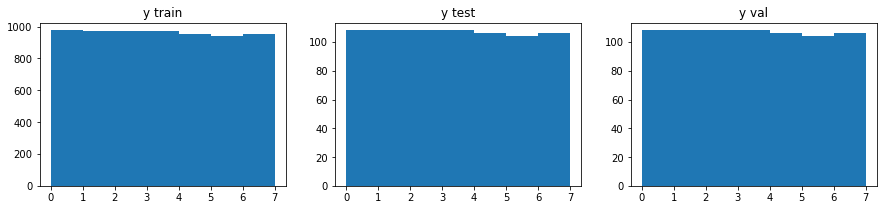

In [9]:
# Plot target distribution
fig,ax =plt.subplots(1,3,figsize=(15,3))

bins = [0,1,2,3,4,5,6,7]

ax[0].hist(y_train,bins=bins)
ax[0].set_title('y train')
ax[1].hist(y_test,bins=bins)
ax[1].set_title('y test')
ax[2].hist(y_val,bins=bins)
ax[2].set_title('y val')

จากการดู distribution ของ train, test และ validation ใน Column y (Emoji) จะมี distribution ของแต่ละ class พอ ๆ กัน จึงสามารถนำไปใช้ได้เลย เพราะ distribution ในการทำนายไม่เกิด bias มากเกินไป

### Preprocess data: Tokenizer & Padding

### - Tokenizer

In [10]:
# Define parameter
max_word = 5000
maxlen = 50 # ค่าเดิมตอนเรียนในคาบเป็น 20 นะ ลองปรับดูเฉย ๆ 
max_features = 5000

In [11]:
# Define Tokenizer
tokenizer = text.Tokenizer(num_words = max_word) # สร้าง corpus(คลังคําศัพท์ว่า คำ ๆ นี้มีค่าอะไรในลักษณะตัวเลข) โดยมีคำในคลังทั้งหมดเป็น max_word
tokenizer.fit_on_texts(x_train)

In [12]:
tokenizer.word_index

{'i': 1,
 'the': 2,
 'a': 3,
 'to': 4,
 'my': 5,
 'and': 6,
 'was': 7,
 'when': 8,
 'of': 9,
 'in': 10,
 'had': 11,
 'me': 12,
 'that': 13,
 'for': 14,
 'not': 15,
 'with': 16,
 'it': 17,
 'at': 18,
 'on': 19,
 'he': 20,
 'very': 21,
 'friend': 22,
 'felt': 23,
 'an': 24,
 'she': 25,
 'her': 26,
 'we': 27,
 'one': 28,
 'as': 29,
 'about': 30,
 'this': 31,
 'from': 32,
 'after': 33,
 'time': 34,
 'by': 35,
 'were': 36,
 'did': 37,
 'but': 38,
 'out': 39,
 'him': 40,
 'who': 41,
 'because': 42,
 'his': 43,
 'been': 44,
 'got': 45,
 'have': 46,
 'some': 47,
 'which': 48,
 'home': 49,
 'would': 50,
 'friends': 51,
 'up': 52,
 'told': 53,
 'so': 54,
 'day': 55,
 'mother': 56,
 'they': 57,
 'be': 58,
 'do': 59,
 'school': 60,
 'people': 61,
 'went': 62,
 'person': 63,
 'there': 64,
 'saw': 65,
 'our': 66,
 'first': 67,
 'is': 68,
 'could': 69,
 'came': 70,
 'night': 71,
 'father': 72,
 'go': 73,
 'all': 74,
 "didn't": 75,
 'made': 76,
 'mine': 77,
 'girl': 78,
 'having': 79,
 'back': 80,
 'o

In [13]:
tokenizer.num_words

5000

### - Padding
เนื่องจากในแต่ละประโยคมีความยาวไม่เท่ากัน เวลาจะเอาไปใส่ใน model จึงต้องให้มีความยาวของประโยคที่ใส่เข้าไปเท่า ๆ กันในการเป็น input data เพื่อให้ไม่เกิดปัญหาต่าง ๆ เช่น error ของ input size เป็นต้น จึงได้ทำ Padding ซึ่งเป็นการเติม 0 ให้กับ data ที่มีขนาดไม่เท่ากับที่เราจะใช้ เพื่อให้ขนาดเท่ากับที่เราต้องการ โดยใช้คำสั่ง .pad_sequences 

In [14]:
# Preprocess data function
def preprocess_fn(data):
    sequeces = tokenizer.texts_to_sequences(data)
    padding_sequences = sequence.pad_sequences(sequeces,maxlen = maxlen) # maxlen เป็นการกำหนดว่าใน 1 ประโยค ควรมีความยาวเท่าไร
    
    return padding_sequences,sequeces

In [15]:
# Preprocess data
x_train,sequeces_x_train =  preprocess_fn(x_train)
x_val,sequeces_x_val = preprocess_fn(x_val)
x_test,sequeces_x_test = preprocess_fn(x_test)

In [16]:
x_train

array([[1406, 3199,   27, ...,    6, 1529,   93],
       [   0,    0,    0, ...,  408,    4,   12],
       [   0,    0,    0, ...,   11,  172,  173],
       ...,
       [   0,    0,    0, ...,  127,    5,   22],
       [   0,    0,    0, ...,   86, 1403,   12],
       [   0,    0,    0, ...,  981,    4,   12]])

In [17]:
sequeces_x_train

[[188,
  9,
  3,
  1406,
  3199,
  27,
  11,
  4,
  221,
  17,
  107,
  42,
  5,
  100,
  240,
  2584,
  4,
  17,
  27,
  202,
  17,
  4,
  3,
  98,
  41,
  402,
  784,
  6,
  1528,
  9,
  81,
  784,
  14,
  338,
  4,
  719,
  27,
  62,
  4,
  345,
  66,
  3199,
  17,
  7,
  314,
  561,
  35,
  2,
  81,
  4453,
  6,
  1529,
  93],
 [1, 46, 23, 31, 161, 8, 3, 63, 164, 1, 661, 6, 720, 408, 4, 12],
 [304,
  18,
  321,
  87,
  721,
  4,
  345,
  3,
  96,
  456,
  10,
  242,
  33,
  26,
  188,
  1,
  23,
  21,
  111,
  6,
  1204,
  1,
  11,
  172,
  173],
 [1,
  688,
  4,
  5,
  56,
  19,
  2,
  507,
  25,
  11,
  1663,
  508,
  6,
  7,
  382,
  4,
  58,
  2162,
  1,
  374,
  4,
  578,
  26,
  2,
  633,
  9,
  2,
  579,
  6,
  133,
  130,
  2163,
  66,
  562,
  25,
  202,
  12,
  2,
  633,
  10,
  722],
 [8,
  4454,
  16,
  3200,
  457,
  1664,
  114,
  5,
  121,
  6,
  1882,
  12,
  4,
  221,
  88,
  152,
  103,
  383,
  188],
 [45, 220, 67, 1142, 143],
 [8,
  1,
  458,
  13,
  1,
  11,
  

### Build a model with word embedding

### Model ที่ 1: Simple RNN

In [18]:
# Define model
rnn = models.Sequential()
# layers.Embedding เป็นการบอกว่าข้อมูลที่เอาเข้ามาให้อยู่ในรูปแบบ vector
rnn.add(layers.Embedding(max_features, 32, input_length = maxlen)) # 32 คือ ขนาด output ที่ต้องการให้ออกมา

rnn.add(layers.SimpleRNN(32)) # neuron ที่ใส่จะมีขนาดเท่ากับ output ที่รับมาจาก Embedding
rnn.add(layers.Dense(64, activation = 'elu'))
rnn.add(layers.Dense(7, activation = 'softmax'))

In [19]:
# Compile model
rnn.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

In [20]:
# Show model structure
rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 32)            160000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 7)                 455       
                                                                 
Total params: 164,647
Trainable params: 164,647
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Fit model
his =  rnn.fit(x_train,y_train,epochs=5,batch_size=32,validation_data=(x_val,y_val))

Epoch 1/5
211/211 [==============================] - 4s 12ms/step - loss: 1.9197 - acc: 0.1915 - val_loss: 1.8708 - val_acc: 0.2286
Epoch 2/5
211/211 [==============================] - 2s 11ms/step - loss: 1.5799 - acc: 0.4269 - val_loss: 1.7071 - val_acc: 0.3382
Epoch 3/5
211/211 [==============================] - 2s 11ms/step - loss: 1.2158 - acc: 0.5749 - val_loss: 1.6536 - val_acc: 0.3596
Epoch 4/5
211/211 [==============================] - 2s 11ms/step - loss: 0.9254 - acc: 0.6933 - val_loss: 1.9047 - val_acc: 0.3329
Epoch 5/5
211/211 [==============================] - 2s 11ms/step - loss: 0.6837 - acc: 0.7821 - val_loss: 2.0351 - val_acc: 0.3436


Last train accuracy: 0.7820855379104614
Last validation accuracy: 0.3435828983783722


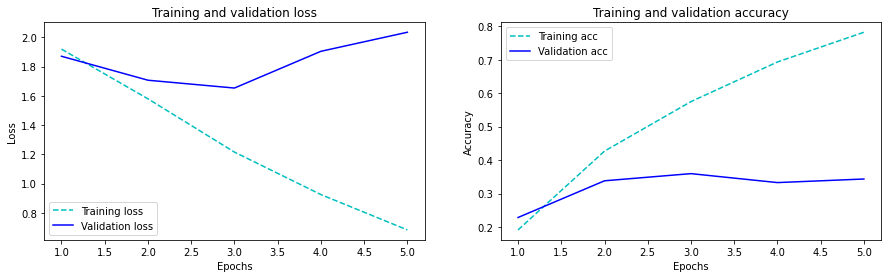

In [23]:
# Plot accuracy and loss over each epochs
fn.show_result(his)

จากกราฟทั้ง 2 จะเห็นว่า validation set มีผลลัพธ์ไม่ค่อยดีมากนัก เมื่อเทียบกับ train set คาดว่าเกิดปัญหา overfitting จึงต้องปรับโครงสร้าง model และ hyperparameter ดู

### Model ที่ 2: LSTM

In [24]:
# Define model
lstm = models.Sequential()
lstm.add(layers.Embedding(max_features, 32, input_length = maxlen))

lstm.add(layers.LSTM(32))
lstm.add(layers.Dense(64, activation = 'elu'))
lstm.add(layers.Dense(7, activation = 'softmax'))

In [25]:
# Compile model
lstm.compile(optimizer = 'rmsprop',loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

In [26]:
# Show model structure
lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 32)            160000    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dense_3 (Dense)             (None, 7)                 455       
                                                                 
Total params: 170,887
Trainable params: 170,887
Non-trainable params: 0
_________________________________________________________________


In [27]:
# Fit model
his2 =  lstm.fit(x_train, y_train, epochs = 5, batch_size = 32, validation_data = (x_val,y_val))

Epoch 1/5
211/211 [==============================] - 6s 21ms/step - loss: 1.8503 - acc: 0.2380 - val_loss: 1.6779 - val_acc: 0.3142
Epoch 2/5
211/211 [==============================] - 4s 19ms/step - loss: 1.4998 - acc: 0.4097 - val_loss: 1.5217 - val_acc: 0.3957
Epoch 3/5
211/211 [==============================] - 4s 18ms/step - loss: 1.2575 - acc: 0.5024 - val_loss: 1.4342 - val_acc: 0.4519
Epoch 4/5
211/211 [==============================] - 4s 18ms/step - loss: 1.0792 - acc: 0.5887 - val_loss: 1.3743 - val_acc: 0.5201
Epoch 5/5
211/211 [==============================] - 4s 18ms/step - loss: 0.9380 - acc: 0.6549 - val_loss: 1.3879 - val_acc: 0.5361


Last train accuracy: 0.6549316644668579
Last validation accuracy: 0.5360962748527527


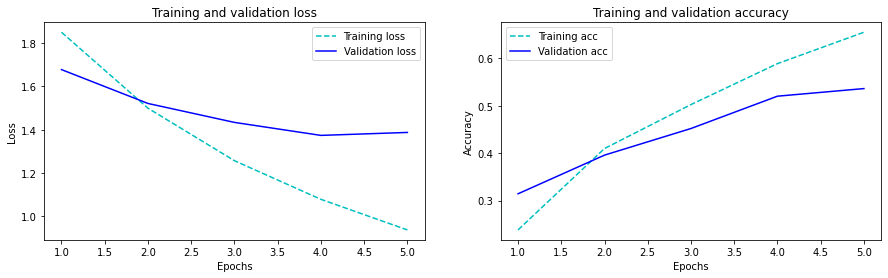

In [28]:
# Plot accuracy and loss over each epochs
fn.show_result(his2)

### Evaluate Model
Baseline of the model is 14.28% (Random prediction)

### Evaluate Model ที่ 1: Simple RNN

In [29]:
# Preprocess test data
rnn.evaluate(x_test,y_test)

24/24 [==============================] - 0s 3ms/step - loss: 2.0351 - acc: 0.3436


[2.0350701808929443, 0.3435828983783722]

In [31]:
# Show confusino matrix and prediction report
fn.evaluation_report(rnn,x_test,y_test)

[[54 12  8 13  7  8  6]
 [ 7 58 18  3  3 12  7]
 [ 7 16 19  7 13 26 20]
 [10  5 15 42  7 16 13]
 [ 4  8 18  4 39 15 18]
 [ 6 23 19  6 13 23 14]
 [ 7 10 20 12 15 20 22]]
              precision    recall  f1-score   support

           0       0.57      0.50      0.53       108
           1       0.44      0.54      0.48       108
           2       0.16      0.18      0.17       108
           3       0.48      0.39      0.43       108
           4       0.40      0.37      0.38       106
           5       0.19      0.22      0.21       104
           6       0.22      0.21      0.21       106

    accuracy                           0.34       748
   macro avg       0.35      0.34      0.35       748
weighted avg       0.35      0.34      0.35       748

Loss: 2.0350701808929443 Accuracy: 0.3435828983783722


array([1, 3, 4, 4, 2, 3, 2, 5, 0, 2, 2, 3, 0, 4, 5, 1, 6, 6, 5, 6, 4, 1,
       1, 4, 6, 6, 4, 1, 4, 5, 3, 5, 2, 4, 4, 0, 6, 4, 4, 0, 0, 6, 0, 1,
       4, 6, 3, 3, 6, 3, 5, 3, 1, 5, 2, 3, 5, 1, 6, 5, 0, 1, 0, 0, 3, 6,
       2, 5, 5, 0, 4, 5, 1, 0, 0, 2, 2, 3, 3, 2, 2, 2, 4, 3, 5, 6, 4, 5,
       2, 4, 0, 1, 5, 2, 3, 6, 3, 3, 1, 5, 5, 6, 2, 2, 4, 1, 5, 0, 0, 3,
       5, 0, 3, 1, 0, 1, 6, 4, 0, 5, 1, 2, 1, 4, 2, 1, 2, 3, 2, 4, 6, 1,
       6, 3, 1, 0, 4, 2, 4, 2, 6, 1, 4, 2, 1, 2, 6, 1, 3, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 4, 2, 2, 1, 6, 0, 3, 3, 2, 3, 1, 3, 2, 0, 4, 0, 0, 5,
       4, 6, 1, 4, 5, 4, 1, 1, 0, 1, 0, 3, 5, 2, 1, 1, 0, 3, 3, 5, 6, 3,
       2, 6, 4, 4, 2, 0, 5, 1, 5, 2, 1, 5, 0, 5, 4, 3, 1, 3, 3, 5, 2, 5,
       6, 2, 6, 2, 2, 4, 2, 1, 2, 4, 3, 0, 5, 0, 1, 6, 5, 4, 2, 1, 6, 2,
       3, 4, 6, 5, 0, 1, 6, 1, 3, 5, 1, 5, 3, 1, 6, 5, 3, 6, 2, 0, 3, 2,
       5, 6, 2, 5, 0, 6, 4, 2, 3, 6, 0, 6, 1, 5, 0, 3, 2, 0, 1, 1, 2, 3,
       2, 4, 5, 3, 6, 4, 0, 5, 0, 5, 2, 2, 5, 1, 5,

In [32]:
rnn.save('model1.h5')

จะได้ว่า Model ที่ 1: Simple RNN มี accuracy อยู่ที่ 0.35 และในแต่ละ class มีค่า precision ไม่สูงมากนัก

### Evaluate Model ที่ 2: LSTM

In [33]:
# Preprocess test data
lstm.evaluate(x_test,y_test)

24/24 [==============================] - 0s 4ms/step - loss: 1.3879 - acc: 0.5361


[1.3878995180130005, 0.5360962748527527]

In [34]:
# Show confusino matrix and prediction report
fn.evaluation_report(lstm,x_test,y_test)

[[75  1  3  6  5 14  4]
 [ 3 73 10  8  8  5  1]
 [ 2  7 32  7 16 28 16]
 [ 6  2  7 62  8 13 10]
 [ 6  4  3  4 65 19  5]
 [ 6  3 18  2 16 46 13]
 [ 3  1 14  8  4 28 48]]
              precision    recall  f1-score   support

           0       0.74      0.69      0.72       108
           1       0.80      0.68      0.73       108
           2       0.37      0.30      0.33       108
           3       0.64      0.57      0.60       108
           4       0.53      0.61      0.57       106
           5       0.30      0.44      0.36       104
           6       0.49      0.45      0.47       106

    accuracy                           0.54       748
   macro avg       0.55      0.54      0.54       748
weighted avg       0.56      0.54      0.54       748

Loss: 1.3878995180130005 Accuracy: 0.5360962748527527


array([1, 6, 6, 4, 2, 3, 6, 5, 3, 1, 4, 3, 3, 4, 4, 1, 2, 6, 4, 6, 4, 5,
       4, 6, 3, 4, 3, 1, 5, 2, 3, 2, 5, 4, 0, 0, 6, 2, 2, 0, 0, 5, 5, 2,
       4, 6, 3, 3, 3, 3, 3, 0, 1, 5, 5, 5, 5, 1, 0, 5, 0, 1, 0, 0, 0, 6,
       6, 6, 4, 3, 4, 4, 1, 0, 0, 4, 2, 3, 6, 6, 6, 5, 2, 0, 5, 6, 5, 4,
       2, 5, 5, 1, 4, 6, 0, 3, 0, 3, 5, 5, 2, 1, 5, 5, 4, 4, 5, 0, 0, 3,
       2, 2, 0, 2, 0, 1, 4, 6, 3, 5, 1, 5, 5, 4, 4, 4, 0, 0, 5, 4, 2, 5,
       1, 6, 1, 0, 4, 6, 4, 2, 1, 4, 6, 3, 3, 5, 5, 5, 3, 1, 1, 1, 2, 1,
       0, 1, 0, 6, 4, 5, 2, 6, 4, 0, 6, 3, 5, 2, 2, 3, 1, 0, 4, 0, 5, 2,
       5, 4, 1, 4, 6, 2, 5, 5, 0, 2, 0, 6, 1, 3, 6, 1, 3, 3, 0, 3, 6, 4,
       4, 2, 5, 4, 2, 4, 5, 2, 5, 2, 1, 1, 0, 5, 5, 0, 2, 3, 0, 2, 4, 5,
       5, 2, 4, 1, 2, 5, 4, 0, 3, 4, 5, 0, 4, 0, 1, 5, 5, 5, 6, 1, 6, 1,
       0, 4, 5, 6, 0, 1, 5, 5, 5, 1, 4, 6, 3, 2, 4, 4, 3, 5, 4, 0, 3, 6,
       3, 4, 6, 5, 6, 5, 4, 5, 5, 6, 6, 4, 1, 2, 3, 6, 2, 0, 1, 4, 6, 5,
       2, 2, 5, 0, 6, 1, 3, 5, 0, 5, 4, 5, 4, 1, 6,

In [35]:
lstm.save('model2.h5')

จะได้ว่า Model ที่ 2: LSTM มี accuracy อยู่ที่ 0.55 และในแต่ละ class มีค่า precision ที่สูงในระดับหนึ่ง

## In-class: ลองสร้าง model เอง

### Model ที่ 3: GRU (ลองสร้างเอง)

In [36]:
# Define model
from keras import regularizers
from keras.layers import Dense, Dropout, SpatialDropout1D


GRU = models.Sequential()
GRU.add(layers.Embedding(max_features,128,input_length=maxlen))

GRU.add(SpatialDropout1D(0.2))

GRU.add(layers.GRU(128, dropout=0.5, 
                   recurrent_dropout=0.5)) 
        
GRU.add(layers.Dense(64,activation='elu'))
GRU.add(layers.Dense(7,activation='softmax'))

In [37]:
# Compile model
GRU.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['acc'])


In [38]:
# Show model structure
GRU.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 128)           640000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 128)          0         
 ropout1D)                                                       
                                                                 
 gru (GRU)                   (None, 128)               99072     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 7)                 455       
                                                                 
Total params: 747,783
Trainable params: 747,783
Non-trainable params: 0
________________________________________________

In [39]:
# Fit model
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta = 0.0001, mode='max')
his3 =  GRU.fit(x_train,y_train,epochs=20,
                    batch_size=25,
                    validation_data=(x_val,y_val),
                    validation_split = 0.2,
                    callbacks=[early_stop])

Epoch 1/20
216/216 [==============================] - 15s 60ms/step - loss: 1.8732 - acc: 0.2332 - val_loss: 1.6815 - val_acc: 0.3563
Epoch 2/20
216/216 [==============================] - 13s 59ms/step - loss: 1.3843 - acc: 0.4994 - val_loss: 1.3928 - val_acc: 0.4848
Epoch 3/20
216/216 [==============================] - 13s 58ms/step - loss: 1.0074 - acc: 0.6442 - val_loss: 1.3457 - val_acc: 0.5316
Epoch 4/20
216/216 [==============================] - 13s 60ms/step - loss: 0.7847 - acc: 0.7274 - val_loss: 1.3822 - val_acc: 0.5471


Last train accuracy: 0.7273908853530884
Last validation accuracy: 0.5471417903900146


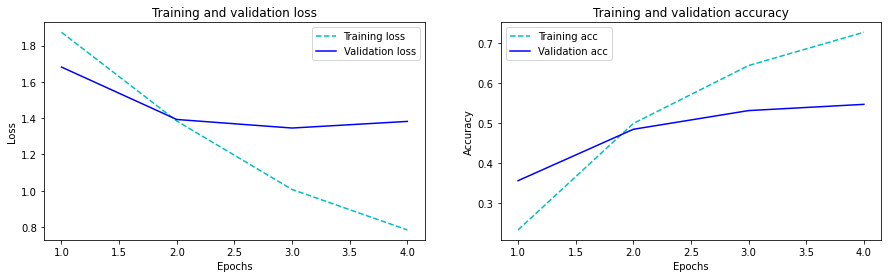

In [40]:
fn.show_result(his3)

### Evaluate Model ที่ 3: GRU (ลองสร้างเอง)

In [41]:
# Preprocess test data
GRU.evaluate(x_test,y_test)

24/24 [==============================] - 0s 9ms/step - loss: 1.3605 - acc: 0.5241


[1.3604872226715088, 0.5240641832351685]

In [42]:
# Show confusino matrix and prediction report
fn.evaluation_report(GRU,x_test,y_test)

[[74  7  1 12  4  7  3]
 [ 4 74  6  9  5  5  5]
 [ 4 10 40  9 13 14 18]
 [ 6 11 14 59  1 12  5]
 [ 7  7  8  6 57 17  4]
 [ 4 11 15  8  9 38 19]
 [ 5  8 14  8  2 19 50]]
              precision    recall  f1-score   support

           0       0.71      0.69      0.70       108
           1       0.58      0.69      0.63       108
           2       0.41      0.37      0.39       108
           3       0.53      0.55      0.54       108
           4       0.63      0.54      0.58       106
           5       0.34      0.37      0.35       104
           6       0.48      0.47      0.48       106

    accuracy                           0.52       748
   macro avg       0.53      0.52      0.52       748
weighted avg       0.53      0.52      0.52       748

Loss: 1.3604872226715088 Accuracy: 0.5240641832351685


array([1, 6, 3, 5, 6, 3, 0, 2, 3, 1, 4, 3, 1, 4, 1, 1, 3, 2, 4, 6, 4, 0,
       4, 6, 0, 4, 3, 1, 4, 2, 3, 2, 5, 4, 3, 0, 6, 4, 6, 0, 0, 4, 5, 2,
       4, 2, 3, 3, 3, 3, 1, 0, 1, 0, 5, 5, 3, 1, 0, 6, 0, 1, 0, 0, 0, 6,
       2, 2, 5, 3, 4, 5, 1, 0, 0, 4, 2, 3, 6, 2, 6, 2, 3, 0, 5, 5, 6, 5,
       2, 6, 0, 1, 5, 6, 0, 1, 0, 3, 5, 6, 2, 2, 1, 0, 5, 1, 0, 0, 0, 3,
       6, 6, 0, 1, 0, 1, 5, 4, 3, 6, 1, 5, 3, 1, 2, 4, 1, 0, 6, 4, 2, 2,
       3, 6, 1, 0, 5, 6, 4, 2, 1, 5, 6, 5, 3, 4, 5, 5, 3, 1, 1, 0, 2, 1,
       5, 1, 0, 1, 4, 4, 2, 5, 1, 0, 2, 3, 4, 3, 2, 3, 1, 0, 4, 0, 0, 5,
       2, 2, 1, 4, 5, 2, 1, 5, 3, 2, 0, 6, 0, 3, 3, 1, 3, 3, 0, 5, 2, 4,
       4, 6, 6, 4, 1, 1, 5, 1, 5, 2, 1, 1, 0, 0, 4, 0, 5, 3, 3, 2, 1, 5,
       3, 1, 4, 4, 2, 2, 4, 1, 3, 4, 4, 0, 5, 0, 1, 3, 6, 5, 6, 5, 6, 5,
       0, 4, 4, 2, 0, 1, 5, 0, 5, 5, 2, 5, 3, 5, 4, 5, 3, 2, 1, 0, 3, 6,
       3, 4, 6, 5, 6, 6, 4, 0, 5, 1, 6, 6, 4, 2, 3, 3, 2, 0, 1, 1, 6, 0,
       5, 2, 5, 0, 6, 4, 3, 6, 0, 5, 2, 6, 4, 1, 6,

เมื่อลองเปรียบเทียบกับ model ที่ลองสร้างเอง คือ GRU และ model ที่มีในคาบทั้ง RNN และ LSTM จะเห็นว่า GRU model มี accuracy อยู่ที่ 0.53 ซึ่งน้อยกว่า 0.55 ของ LSTM model ที่มีในคาบนิดเดียว แต่ก็ยังไม่ดีเท่าที่ควร และในแต่ละ class มีค่า precision ที่สูงในระดับหนึ่ง พอ ๆ กับ LSTM model 

ถึงแม้ model ที่ลองสร้างเอง คือ GRU จะไม่มีการเกิด overfitting มากนัก เพราะมีการปรับโครงสร้าง model และ hyperparameter แล้วก็ตาม แต่ในอนาคตอาจต้อง ลองปรับการสร้าง model ดู และ ลองปรับวิธีการ Preprocess data หรือลองเพิ่มจำนวนข้อมูลที่ใช้ในการ train และ validation เพื่อให้ model มีประสิทธิภาพมากขึ้น

---

# Play with your model
**Emoji**
0 = joy 😆
1 = fear 😱
2 = anger 😡
3 = sadness 😭
4 = disgust 🤮
5 = shame 😳
6 = guilt 😞

In [43]:
# Define predict function
def predict_emoji(input_text,model):
    
    prepro_input = preprocess_fn([input_text])
    prepro_input = prepro_input[0]
    pred_class = model.predict(prepro_input).argmax(axis =1)
    
    label_to_emoji = ['😆','😱','😡','😭','🤮','😳','😞']
    
    result = label_to_emoji[int(pred_class)]
    
    print('%s %s'%(input_text,result))

### ลองกับ Model ที่ 1: Simple RNN

In [44]:
# Test your model
input_text ='I like this class'
predict_emoji(input_text,rnn)

I like this class 😳


In [45]:
input_text = 'Cats can be either liquid or solid, depending on the circumstances'
predict_emoji(input_text,rnn)

Cats can be either liquid or solid, depending on the circumstances 😞


In [46]:
input_text = 'if they don’t see the value of having you, don’t try to convince them.'
predict_emoji(input_text,rnn)

if they don’t see the value of having you, don’t try to convince them. 😳


In [47]:
input_text = 'Text from you makes my heart beating so fast'
predict_emoji(input_text,rnn)

Text from you makes my heart beating so fast 😱


In [48]:
input_text = 'I get butterflies in my stomach whenever I have to speak in front of a lot of people.'
predict_emoji(input_text,rnn)

I get butterflies in my stomach whenever I have to speak in front of a lot of people. 😡


### ลองกับ Model ที่ 2: LSTM

In [49]:
# Test your model
input_text = 'I like this class'
predict_emoji(input_text,lstm)

I like this class 🤮


In [50]:
input_text = 'Cats can be either liquid or solid, depending on the circumstances'
predict_emoji(input_text,lstm)

Cats can be either liquid or solid, depending on the circumstances 😆


In [51]:
input_text = 'if they don’t see the value of having you, don’t try to convince them.'
predict_emoji(input_text,lstm)

if they don’t see the value of having you, don’t try to convince them. 😳


In [52]:
input_text = 'Text from you makes my heart beating so fast'
predict_emoji(input_text,lstm)

Text from you makes my heart beating so fast 😱


In [53]:
input_text = 'I get butterflies in my stomach whenever I have to speak in front of a lot of people.'
predict_emoji(input_text,lstm)

I get butterflies in my stomach whenever I have to speak in front of a lot of people. 🤮


### ลองกับ Model ที่ 3: GRU (ลองทำเอง)

In [54]:
# Test your model
input_text = 'I like this class'
predict_emoji(input_text,GRU)

I like this class 😆


In [55]:
input_text = 'Cats can be either liquid or solid, depending on the circumstances'
predict_emoji(input_text,GRU)

Cats can be either liquid or solid, depending on the circumstances 😱


In [56]:
input_text = 'if they don’t see the value of having you, don’t try to convince them.'
predict_emoji(input_text,GRU)

if they don’t see the value of having you, don’t try to convince them. 😞


In [57]:
input_text = 'Text from you makes my heart beating so fast'
predict_emoji(input_text,GRU)

Text from you makes my heart beating so fast 😱


In [58]:
input_text = 'I get butterflies in my stomach whenever I have to speak in front of a lot of people.'
predict_emoji(input_text,GRU)

I get butterflies in my stomach whenever I have to speak in front of a lot of people. 😳


---